In [1]:
import mammoth
from autocsv import data_csv
import fairbench as fb

In [2]:
import os
os.getcwd()

'/home/luser/Mammoth'

### We need to import some packages as above
### In this example we will the default credit card payment data as our proxy
### To load the load the data we will use fairbench
### We know some info about the dataset from the official website of the data https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

In [3]:
numeric = [ 'X1','X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23']
categorical = ['X2', 'X3', 'X4']
sensitive = [ 'X2', 'X4', 'X5'] #proxy for ['Sex', 'Marital Status', 'Age']

In [4]:
dataset_uri = (
        "https://archive.ics.uci.edu/static/public/350/data.csv"
    )

In [5]:
with mammoth.testing.Env(data_csv) as env:
    dataset = env.data_csv(
            dataset_uri, categorical=categorical, numeric=numeric, labels="Y", delimiter=","
        )

### The data is loaded as familiar dataframe format. Now let's look into a snapshot of the data

In [6]:
dataset.data

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### The data needs to normalized and cleaned. Below I have provided a preprocessing that I often use:

In [7]:
from sklearn import preprocessing
import numpy as np
def preprocess(df, categorical, numerical, sensitive, classf, sex='', race='', age='', marg=''):
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])
    
    """ Feature normalization and one hot encoding """
    # convert class label 0 to -1
    y = df[classf].copy(deep=True)
    y =  np.array([int(k) for k in y])
    y[y==0] = -1
    X=df.copy(deep=True).drop(columns=['ID', 'Y'])
    p_group=[0,0,0]
    #X= np.array([]).reshape(len(y), 0)
    for attr in X.columns:
        vals = X[attr]
        if attr==age:
            va=[v for v in vals]           
        if attr==sex or attr==race:
            vals=[1 if v==1 else 0 for v in vals]
        if attr==marg:
            vals=[0 if v==1 else 1 for v in vals]
        if attr in numerical:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            if attr==age:
                v=[vals[i][0] for i in range(len(vals)) if va[i]==25 or va[i]==60]
                v=list(set(v))
                #print(v)
                p_group[sensitive.index(age)]=[min(v),max(v)]
            
        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()
            lb.fit(vals)
            vals = lb.transform(vals)
        X[attr]=vals
    return X, y, p_group

In [8]:
X,y,p_group=preprocess(dataset.data, categorical,numeric,sensitive,'Y',age='X5', marg='X4', sex='X2')

In [9]:
s_index=[X.columns.get_loc(s) for s in sensitive]

### Splitting data into train test sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.to_numpy(), y, test_size=0.5, random_state=42)

### Training MFPPC aka our MMM-fair classifier

In [11]:
from MFPPB import Multi_Fair

In [12]:
mppfb=Multi_Fair(n_estimators=500,saIndex=s_index,saValue=p_group)
#,protected_attr=['Sex', 'Marital Status', 'Age'])

In [13]:
mppfb.fit(X_train,y_train)

Multi_Fair(n_estimators=500, saIndex=[1, 3, 4],
           saValue=[0, 0, [-1.1375335092714727, 2.659488361359545]])

In [14]:
mppfb.update_theta(criteria='all')

In [15]:
mppfb.theta

43

In [16]:
y_preds= mppfb.predict(X_test)

## Interactive Pareto visualization
### The visualization can be used for any model given that we store multiple Multi-objective solutions. 
### For non-MOO model this can be done by checkpointing prediction model at various stage and recording the errors for every objective at each checkpoint. If pseudoweights not available either comment off 'hidden_data' or pass the copy of objective error values as dummy weights. 

In [29]:
def see_pareto(self):
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
    def plot2d(x,y,axis_names):
        pass
    def plot3d(x = [1, 2, 3, 4, 5],y = [2, 3, 1, 4, 5],z = [3, 1, 2, 5, 4],weights = [1,2,3,4,5],criteria='all',axis_names=['X','Y','Z']):
        # Create the figure
        hidden_data=[str(np.around(weights[i],2)) for i in range(len(weights))]
        fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
        
        # Add 3D scatter plot
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color='blue'), 
                                   name='Points',text=hidden_data, customdata=hidden_data ), row=1, col=1)
        
        # Define callback function for selection event
        def update_point(trace, points, selector):
            selected_points = [(trace.x[i], trace.y[i], trace.z[i]) for i in points.point_inds]
            selected_hidden_data = [trace.customdata[i] for i in points.point_inds]
            print("Selected Points:", selected_points,selected_hidden_data)
        
        # Assign callback function to plot
        fig.data[0].on_selection(update_point)
        
        # Update layout
        fig.update_layout(title=criteria+'-objectives Pareto Plot - Select Points to Return Vector',
                         scene=dict(
                                    xaxis_title='X:'+axis_names[0],
                                    yaxis_title='Y:'+ axis_names[1],
                                    zaxis_title='Z:'+ axis_names[2]
                                ),
                                width=1000,  # Set the width of the plot
                                height=700 )
        
        # Show plot
        fig.show()
    
    
    plot3d(x=self.PF[:,0],y=self.PF[:,1],z=self.PF[:,2], weights=self.pseudo,
           axis_names=['Acc.','Balanc. Acc', 'MMM-fair'])
    #self.update_theta(criteria='fairness')
    if len(self.prot_attr)>2:
        plot3d(x=self.FPF[:,0],y=self.FPF[:,1],z=self.FPF[:,2], weights=self.Fpseudo,
               criteria='Fairness',axis_names=self.prot_attr)
    elif len(self.prot_attr)==2:
            plot3d(x=self.FPF[:,0],y=self.FPF[:,1],z=np.zeros_like(self.FPF[:,1]), weights=self.Fpseudo,
               criteria='Fairness',axis_names=self.prot_attr+'')

    else:
        print('Not a Multi-fair')

In [30]:
class obs_stats:
    def __init__(self, pareto_all, pseudoW, pareto_fairness, fair_pseudoW,prot_att):
        self.PF= pareto_all
        self.pseudo=pseudoW
        self.FPF=pareto_fairness
        self.Fpseudo=fair_pseudoW
        self.prot_attr=prot_att
        

In [19]:
mppfb.update_theta(criteria='all')
pf=mppfb.PF
wgts=mppfb.pseudo

In [20]:
mppfb.update_theta(criteria='fairness')
fpf=mppfb.PF
fwgts=mppfb.pseudo

/home/luser/ananconda3/envs/Mammoth/lib/python3.12/site-packages/pymoo/mcdm/pseudo_weights.py:24: RuntimeWarning: invalid value encountered in divide
  pseudo_weights = pseudo_weights / np.sum(pseudo_weights, axis=1)[:, None]


In [31]:
vis_stats=obs_stats(pf,wgts,fpf,fwgts,['Sex', 'Marital Status', 'Age'])

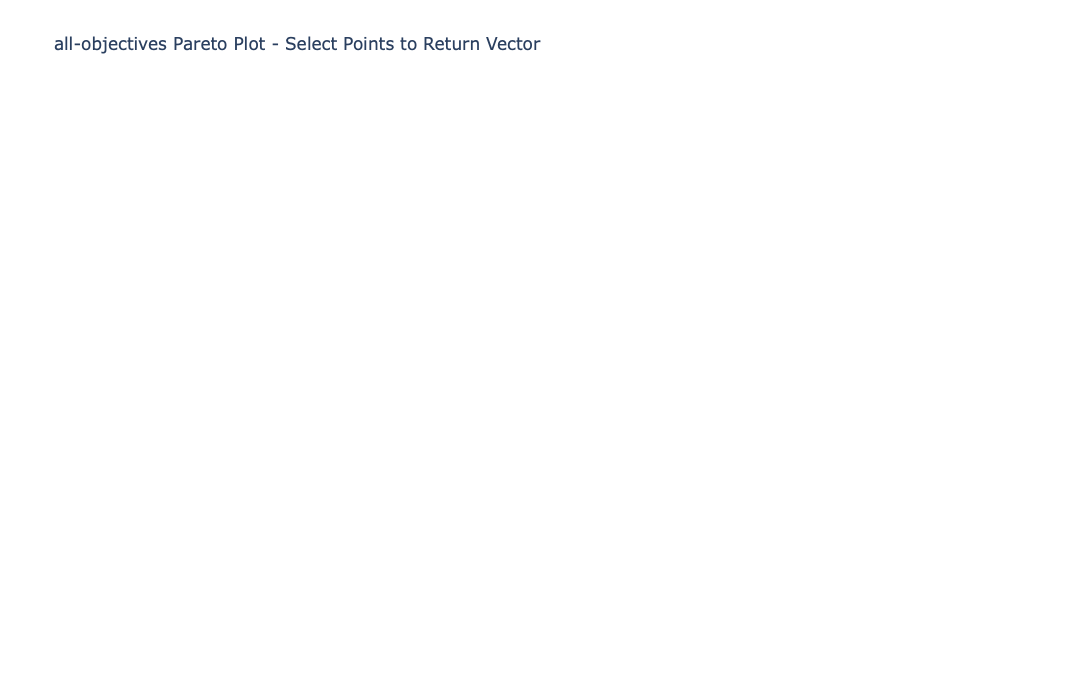

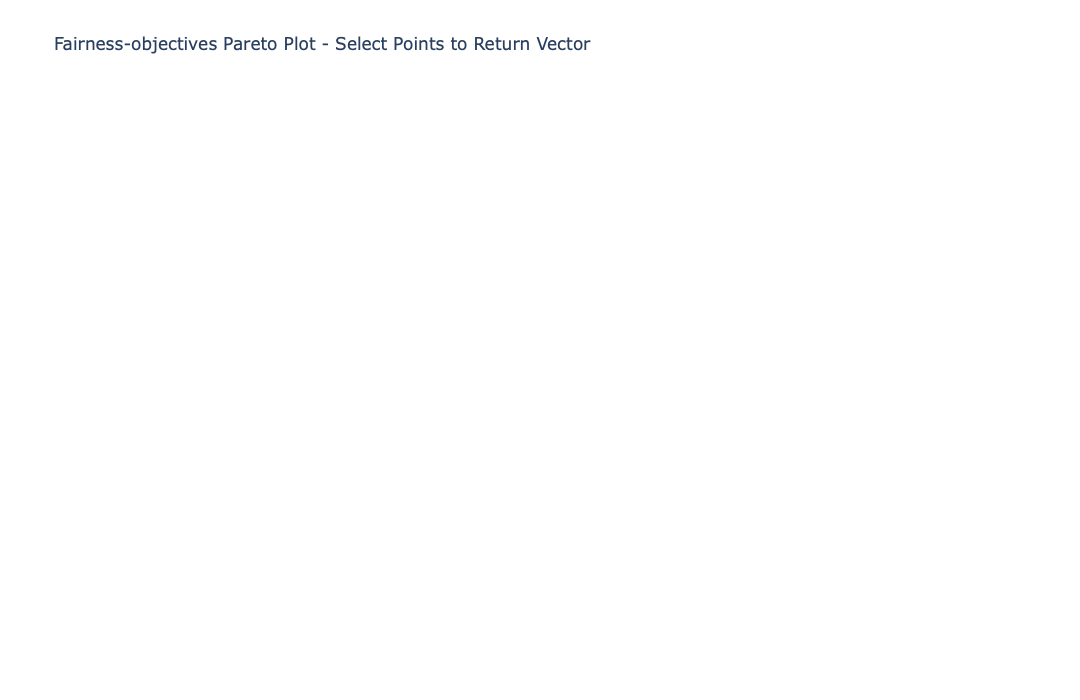

In [32]:
see_pareto(vis_stats)

In [35]:
np.save('mfppb/pareto_stats.npy',{'PF':pf,'pseudo':wgts,'FPF':fpf,'Fpseudo':fwgts})

### Now let's see how to save the trained model as onnx type

In [36]:
from skl2onnx import convert_sklearn, to_onnx
from skl2onnx.common.data_types import FloatTensorType

def convert_to_onnx(custom_model, output_path,X):
    # Ensure the base model is fitted
    assert custom_model.estimators_ is not None, "The model must be fitted before conversion."
    
    # Create a list to hold converted ONNX models
    onnx_models = []
    for i, estimator in enumerate(custom_model.estimators_):
       onnx_model = to_onnx(estimator, X.astype(np.float32)[:1])
       onnx_models.append(onnx_model)

    for i, onnx_model in enumerate(onnx_models):
        with open(f"{output_path}_estimator_{i}.onnx", "wb") as f:
            f.write(onnx_model.SerializeToString())

In [ ]:
convert_to_onnx(mppfb,'./mfppb/',X.to_numpy())

### Need to save other parameters of the ensemble to recreate predictions of the ensemble through ONNX

In [37]:
params={'n_classes':mppfb.n_classes_, 
        'classes':mppfb.classes_, 'alphas':mppfb.estimator_alphas_,
       'theta': mppfb.theta}

In [ ]:
np.save('mfppb/mfppb_params.npy',params)

### Now that we have everything saved, let's load the onnx model 

In [41]:
from kfp import dsl
import numpy as np
import onnxruntime as rt
from io import BytesIO
import urllib.request
import zipfile
import re
class Model:
    integration = dsl.Model
    
class ONNXEnsemble:
    def __init__(self, zip_url):
        self.zip_url = zip_url
        self.models, self.params = self._load_models_and_params_from_zip()

    def _extract_number(self, filename):
        match = re.search(r'_(\d+)\.onnx$', filename)
        return int(match.group(1)) if match else float('inf')
        
    def _load_models_and_params_from_zip(self):
        # Download the zip file into memory
        #with urllib.request.urlopen(self.zip_url) as response:
        #    zip_file_bytes = response.read()

        models = []
        model_names=[]
        params = None
        
        def myk(name):
            return int(re.findall(r'[+-]?\d+',name)[0])

        # Read the zip file
        with zipfile.ZipFile(self.zip_url) as myzip:
            # Extract and load the weights file
            for file_name in myzip.namelist():
                if file_name.endswith('.npy'):
                    with myzip.open(file_name) as param_file:
                        params= np.load(param_file,allow_pickle=True)
                elif file_name.endswith('.onnx'):
                    model_names.append(file_name)
            
            model_names.sort(key=myk)   
          
            for file_name in model_names:        
                with myzip.open(file_name) as model_file:
                    model_bytes = model_file.read()
                    models.append(self.ONNX(model_bytes))
        
        return models, params.item()

    class ONNX(Model):
        def __init__(self, model_bytes):
            self.sess = rt.InferenceSession(model_bytes, providers=["CPUExecutionProvider"])

        def predict(self, x):
            input_name = self.sess.get_inputs()[0].name
            label_name = self.sess.get_outputs()[0].name
            return self.sess.run([label_name], {input_name: x.astype(np.float32)})[0]

    def predict(self, X):
        n_classes = self.params['n_classes']
        classes = self.params['classes'][:, np.newaxis]

        pred = sum((estimator.predict(X)== classes).T * w  for estimator, w in zip(self.models[:self.params['theta'] ], self.params['alphas'][:self.params['theta']]))
        pred /= self.params['alphas'][:self.params['theta']].sum()
        pred[:, 0] *= -1
        preds=classes.take(pred.sum(axis=1) > 0, axis=0)
        return np.squeeze(preds,axis=1)

In [42]:
zip_url ='mfppb.zip'
ensemble = ONNXEnsemble(zip_url)